# Anomaly detection

Welcome to the anomaly detection solutions accelerator.

This accelerator is designed to be a brief but informative introduction on how to use anomaly detection - specifically in BigQuery and GCP to detect anomalies in Snowplow data.

In this example we focus on anomaly detection in a time series - specifically looking at data from the warehouse where dips may indicate problems in tracking or an increase in failed events.

For this notebook you will need:
* Access to a GCP project (and the corresponding project id)
* Permissions to read, write and query objects in BigQuery
* Access to this notebook with execution permissions

You do not need to have a Snowplow pipeline setup as this accelerator provides sample data for you.

This notebook should take 10-15 minutes to run through. It does not require significant compute so you should be able to run everything within the notebook itself (it may take 30 seconds or so to connect).

You should only need to make minimal changes to this notebook - specifically where you see the 'MODIFY ME' text.

In [ ]:
!pip3 install google-cloud-bigquery python-dotenv ipywidgets pandas matplotlib seaborn bigquery_magics
import os
from google.colab import auth
from google.cloud.bigquery import magics

PROJECT_ID = 'com-snplow-sales-gcp' # MODIFY ME - put the project id of your GCP project here, you will need access to a GCP project with BigQuery permissions for your currently logged in Google user
auth.authenticate_user()
os.environ['GCP_PROJECT_ID'] = PROJECT_ID
magics.context.project = PROJECT_ID

First let's have a look at what our timeseries data looks like for the month of June 2024.

We'll be looking at a table with three columns.
collector_tstamp: A truncated (to the hour) UTC timestamp of when an event was received
event_count: A count of the number of enriched events in that period
app_id: The application identifier

The intent of this exercise is to determine statistically significant drops in event counts in a given hour so that we can generate alerts in the future to make us aware that there may be a problem with our data collection.

To start we'll visually plot our data which will make it more easily apparent where these dips exist.

In [1]:
import pandas as pd
test_df = pd.read_csv('https://raw.githubusercontent.com/snowplow-industry-solutions/event-volume-anomaly-detection/refs/heads/main/datasets/anomaly_events_test.csv?token=GHSAT0AAAAAAC2DXSNSS76W6IWTDVJISP42Z5V6FMQ', parse_dates=['collector_tstamp'])

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.lineplot(x='collector_tstamp', y='event_count', data=test_df, marker='o')
plt.xlabel('Timestamp')
plt.ylabel('Event Count')
plt.title('Event Count over Time')
plt.grid(True)
plt.show()


ModuleNotFoundError: No module named 'seaborn'

Now that we've plotted our data we are going to load it into our GCP project (in the scratch.sample_events table) so that we can train our anomaly detection model.

In [ ]:
# First, we'll load our local data into BigQuery to begin training
%load_ext bigquery_magics
from google.cloud import bigquery
client = bigquery.Client(project=PROJECT_ID)

# TODO: use a project id and dataset of your choosing
table_id = f'{PROJECT_ID}.scratch.sample_events' # optionally customise dataset and table name, you will get a 404 if this dataset does not already exist
schema = [
    bigquery.SchemaField("collector_tstamp", bigquery.enums.SqlTypeNames.TIMESTAMP),
    bigquery.SchemaField("event_count", bigquery.enums.SqlTypeNames.INTEGER),
    bigquery.SchemaField("app_id", bigquery.enums.SqlTypeNames.STRING),
    bigquery.SchemaField("event_name", bigquery.enums.SqlTypeNames.STRING)
]

# create the load configuration
job_config = bigquery.LoadJobConfig(
    schema=schema,
    write_disposition="WRITE_TRUNCATE"
)

test_table_name = f'{PROJECT_ID}.scratch.sample_events'
job = client.load_table_from_dataframe(test_df, test_table_name, job_config=job_config)
result = job.result()
test_table = client.get_table(test_table_name)
print(
    "Loaded {} test rows and {} columns to {}".format(
        test_table.num_rows, len(test_table.schema), table_id
    )
)

Loaded 696 test rows and 4 columns to com-snplow-sales-gcp.scratch.sample_events


Now we will create an [ARIMA+](https://cloud.google.com/vertex-ai/docs/tabular-data/forecasting-arima/overview) model based on this data. ARIMA+ is a statistical model that can be used for both timeseries forecasting (predicting the future) as well as anomaly detection.

ARIMA models aim to decompose a time series into their individual components such as trends, seasons, and holiday and incorporate these cyclicty elements into the model. This is far more useful than a model which detects anomalies over a fixed value (e.g., anything about 100), a basic statistical model (any value 2 deviations above the rolling mean) or more complex methods like Holt-Winters that make it more difficult to account for things like holiday periods e.g., Black Friday.

We'll optionally include holidays for a given country to account for spikes or dips in traffic for US public holidays. You can change this value below if you would like to use holidays for a different country.

Running the cell below will create and train the model. This ordinarily takes a few minutes to complete.

In [ ]:
%%bigquery --project $PROJECT_ID
create or replace model scratch.app_id_event_forecast
    options(
        model_type="ARIMA_PLUS",
        time_series_timestamp_col="collector_tstamp",
        time_series_data_col="event_count", -- the thing we are attempting to forecast
        time_series_id_col=["app_id"],

        holiday_region="US"
    )
    AS (
SELECT
    collector_tstamp,
    app_id,
    event_count
FROM
    scratch.sample_events
    )

Query is running:   0%|          |

""


Now that we've trained a forecasting model above, we'll use it to predict any anomalies in our test data set above from 2024. We can do this by creating a table full of anomalies against the detected dataset.

We will write the high confidence (probably > 0.99) anomalies to a table that we can then query later for safekeeping. You can adjust the confidence level below by moving the control left or right. Decreasing the confidence will increase the number of anomalies detected (and as a result potential false positives) and increasing the confidence will reduce the number of anomalies detected.

In [ ]:
import ipywidgets as widgets
confidence = widgets.IntSlider(
    value=99,
    min=0,
    max=100,
    step=5,
    description='Confidence (higher is more confident):',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d'
)
display(confidence)
params = {'confidence': confidence.value}

IntSlider(value=99, continuous_update=False, description='Confidence (higher is more confident):', step=5)

In [ ]:
%%bigquery edf --params $params --project $PROJECT_ID
  create or replace table scratch.anomaly_predictions
  OPTIONS()
  as SELECT
    collector_tstamp,
    app_id,
    event_count,
    is_anomaly,
    lower_bound,
    upper_bound,
    anomaly_probability,
    CASE
        WHEN event_count > upper_bound THEN 'above'
        WHEN event_count < lower_bound THEN 'below'
    END AS direction
    FROM
        ML.DETECT_ANOMALIES(MODEL scratch.app_id_event_forecast)
where
is_anomaly = true
and
anomaly_probability >= @confidence / 100;

Query is running:   0%|          |

Now let's select the anomalous values out into a dataframe from the table that we have just created above (scratch.anomaly_predictions).

In [ ]:
%%bigquery anomalies_df --project $PROJECT_ID
SELECT * FROM scratch.anomaly_predictions

Query is running:   0%|          |

Downloading:   0%|          |

In [ ]:
# show a limited view of 10 anomalies
anomalies_df.head(10)

,collector_tstamp,app_id,event_count,is_anomaly,lower_bound,upper_bound,anomaly_probability,direction
0,2024-06-16 21:00:00+00:00,anomaly_detection1,118.0,True,119.852609,129.651749,0.992577,below
1,2024-06-07 02:00:00+00:00,anomaly_detection1,63.0,True,84.350609,94.149749,1.000000,below
2,2024-06-28 10:00:00+00:00,anomaly_detection1,94.0,True,95.884160,105.683299,0.992832,below
3,2024-06-27 11:00:00+00:00,anomaly_detection1,87.0,True,89.017291,98.816431,0.993817,below
4,2024-06-20 08:00:00+00:00,anomaly_detection1,69.0,True,86.611062,96.410201,1.000000,below
5,2024-06-18 02:00:00+00:00,anomaly_detection1,107.0,True,108.605112,118.404252,0.990261,below
6,2024-06-08 11:00:00+00:00,anomaly_detection1,104.0,True,107.933085,117.732224,0.999307,below
7,2024-06-01 11:00:00+00:00,anomaly_detection1,117.0,True,103.212694,113.011834,0.999350,above
8,2024-06-01 22:00:00+00:00,anomaly_detection1,83.0,True,105.051896,114.851036,1.000000,below
9,2024-06-03 00:00:00+00:00,anomaly_detection1,114.0,True,116.035994,125.835133,0.993944,below


Now that you are a certified data scientist let's turn this frankly downright unappealing table into something that is a little bit more explanatory.

To do that we will take the anomalous values above and replot them against our original timeseries plot of our traffic.

For any data point in this set we will mark it with a red cross.

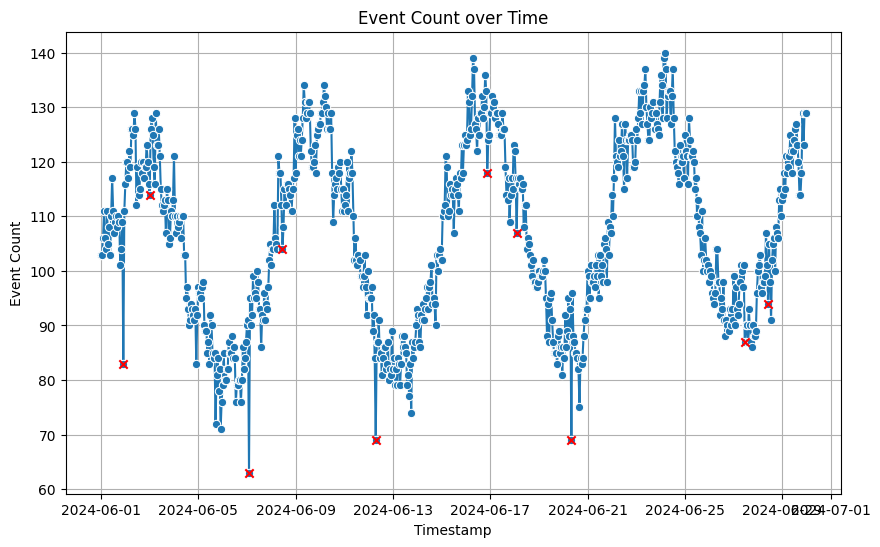

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.lineplot(x='collector_tstamp', y='event_count', data=test_df, marker='o')
plt.xlabel('Timestamp')
plt.ylabel('Event Count')
plt.title('Event Count over Time')
plt.grid(True)
dips = anomalies_df[anomalies_df['direction'] == 'below']

plt.scatter(dips['collector_tstamp'], dips['event_count'], color='r', marker='x', label='Anomaly', zorder=2)

plt.show()

bold text# Well, well, well.

You've made it to the end and what a journey it's been.

What's next? The world is your oyster kid.

Want to run anomaly detection to predict traffic drops when someone accidentally breaks a Google Tag Manager container running Bolivia?

Want to detect when the background noise of a failed event from a mobile application suddenly spikes when Jerry pushes a new version of the app into production?

Want to predict the future of the stock market so you can be prepared to cash out before capitalism inevitably fails?

With Snowplow anything is possible.